In [1]:
import math
import os
import time

In [2]:
from collections import deque
from collections.abc import Iterable
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np

In [3]:
import torch
from torch import nn, optim
from torch.utils import data

from bootstrap import *
from common import io

In [4]:
from vendor import yolact

In [5]:
# Define paths

INPUT_DIR_PATH = os.environ.get('KAGGLE_INPUT_DIR', ROOT_DIR_PATH / '.input')
TRAIN_DATA_DIR_PATH = INPUT_DIR_PATH / \
    'siim-acr-pneumothorax-segmentation' / 'jpeg-images-train'
TEST_DATA_DIR_PATH = INPUT_DIR_PATH / \
    'siim-acr-pneumothorax-segmentation' / 'jpeg-images-test'

In [6]:
backbone_path = 'yolact/resnet101_reducedfc.pth'
batch_size = 8
max_iter = 16
num_workers = 1
torch.set_default_tensor_type('torch.FloatTensor')

In [7]:
loss_types = ['B', 'C', 'M', 'P', 'D', 'E', 'S']

In [8]:


class MovingAverage():
    """ Keeps an average window of the specified number of items. """

    def __init__(self, max_window_size=1000):
        self.max_window_size = max_window_size
        self.reset()

    def add(self, elem):
        """ Adds an element to the window, removing the earliest element if necessary. """
        if not math.isfinite(elem):
            print('Warning: Moving average ignored a value of %f' % elem)
            return

        self.window.append(elem)
        self.sum += elem

        if len(self.window) > self.max_window_size:
            self.sum -= self.window.popleft()

    def append(self, elem):
        """ Same as add just more pythonic. """
        self.add(elem)

    def reset(self):
        """ Resets the MovingAverage to its initial state. """
        self.window = deque()
        self.sum = 0

    def get_avg(self):
        """ Returns the average of the elements in the window. """
        return self.sum / max(len(self.window), 1)

    def __str__(self):
        return str(self.get_avg())

    def __repr__(self):
        return repr(self.get_avg())

In [9]:
class TrainDataset(torch.utils.data.Dataset):

    def __init__(self, transform=None, empty_mask_is_negative=False):
        self.transform = transform
        self.empty_mask_is_negative = empty_mask_is_negative
        self._paths = list(Path(TRAIN_DATA_DIR_PATH).glob('*.jpg'))

    def __len__(self):
        return len(self._paths)

    def __getitem__(self, idx):
        img, attr, mask = io.read_jpg(
            self._paths[idx], self.empty_mask_is_negative)
        if mask is not None:
            mask = 0 < np.sum(np.array(mask), axis=0)

        if self.transform is not None:
            img = self.transform(img)
            mask = self.transform(mask)

        return img, mask

(-0.5, 1023.5, 1023.5, -0.5)

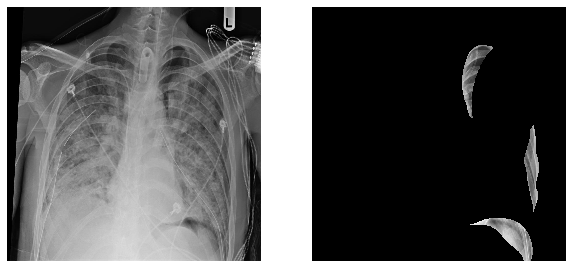

In [10]:
train_dataset = TrainDataset(empty_mask_is_negative=True)

img, mask = train_dataset[2900]
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(img, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(img * mask.astype(np.int), cmap='gray')
plt.axis('off')

In [11]:
dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=2, shuffle=True)

In [12]:
net = yolact.yolact.Yolact()
net.train()
net.init_weights(backbone_path=str(INPUT_DIR_PATH / backbone_path))

In [13]:
#optimizer = optim.SGD(net.parameters(), lr=args.lr, momentum=args.momentum, weight_decay=args.decay)
optimizer = optim.SGD(net.parameters(), lr=0.01)

In [14]:
positive_iou_threshold = 0.3
negative_iou_threshold = 0.3
criterion = yolact.layers.MultiBoxLoss(num_classes=2,
                                       pos_threshold=positive_iou_threshold,
                                       neg_threshold=negative_iou_threshold,
                                       negpos_ratio=3)

In [15]:
# loss counters
loc_loss = 0
conf_loss = 0
#iteration = max(args.start_iter, 0)
iteration = 0
last_time = time.time()

#epoch_size = len(dataset) // args.batch_size
#num_epochs = math.ceil(cfg.max_iter / epoch_size)
epoch_size = len(train_dataset) // batch_size
num_epochs = math.ceil(max_iter / epoch_size)

# Which learning rate adjustment step are we on? lr' = lr * gamma ^ step_index
step_index = 0

In [16]:
data_loader = data.DataLoader(train_dataset, batch_size,
                              num_workers=num_workers,
                              shuffle=True, 
                              pin_memory=True)

In [17]:
epoch_size

1339

In [18]:
def save_path(epoch, iteration): return SavePath(
    cfg.name, epoch, iteration).get_path(root=args.save_folder)


time_avg = MovingAverage()

loss_avgs = {k: MovingAverage(100) for k in loss_types}

print('Begin training!')
print()

Begin training!



In [ ]:
# try-except so you can use ctrl+c to save early and stop training
    iteration = 0
    for epoch in range(num_epochs):
        for datum in data_loader:
                # Stop if we've reached an epoch if we're resuming from start_iter
                if iteration == (epoch+1)*epoch_size:
                    break

                # Stop at the configured number of iterations even if mid-epoch
                if iteration == max_iter:
                    break
                    
                images, masks= datum
                images = torch.from_numpy(np.stack([images / 255] * 3, axis=1)).float()
                masks = torch.from_numpy(np.stack([masks] * 3, axis=1)).float()
                # Forward Pass
                out = net(images)
                
                iteration += 1



In [18]:
max_iter

1024

In [35]:
iteration

0

In [54]:
yolact.utils.augmentations.BackboneTransform()

vendor.submodules.yolact.utils.augmentations.BackboneTransform